## In this version, we find communities first, then we delete the nodes from the network.

### Questoin 7 & 8(a)

In [25]:
library('igraph')
g <- read.graph('./data/movie_edge_weight.txt', format='ncol', directed=FALSE)


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



In [30]:
#genreate genre
movie_genre_file <- file("./data/movieID_genre.txt", open="r")
line <- readLines(movie_genre_file, 1, encoding="latin1")
genre_list <- rep("", vcount(g))
while(length(line) != 0) {
    line <- strsplit(line,"\t\t")
    genre <- line[[1]][3]
    movie_id <- line[[1]][2]
    node_id <- V(g)[V(g)$name == movie_id]
    genre_list[node_id] <- genre
    line <- readLines(movie_genre_file, 1, encoding="latin1")
} 
close(movie_genre_file)

In [31]:
save(genre_list, file = "./data/genreList.RData")

In [32]:
# index the nodes
V(g)$idx <- 1:vcount(g)

V(g)$genre <- genre_list

In [33]:
write_graph(g, "./data/movie_genre_graph.txt", format = "edgelist")

In [35]:
# redundant step for this case
vertices <- V(g)[genre_list != ""]
g.genre <- induced_subgraph(g, vertices, impl = "copy_and_delete")

# Fast Greedy community detection
g.genre.fgc <- cluster_fast_greedy(g.genre)

In [36]:
write_graph(g.genre, "./data/movie_genre_subgraph.txt", format = "edgelist")

In [56]:
save(g.genre.fgc, file = "./data/communities.RData")

In [68]:
# generate n random integers
n <- 10
communities <- sample(1:length(g.genre.fgc), n, replace = FALSE)

# compute the frequency of each genre in a community
for (i in communities) {
    genre_list <- V(g.genre)[g.genre.fgc[[i]]]$genre
    genre_list <- genre_list[genre_list != "None"]
    genre.table <- table(genre_list)
    genre.freq <- prop.table(genre.table)
    
    cat("======= Community", i, "=======\n")
    cat("============================\n")
    
    Genre <- names(genre.table)
    Count <- as.vector(genre.table)
    Freq <- as.vector(genre.freq)
    df <- data.frame(Genre, Count, Freq)
    print(df)
    cat("\n\n")
}

======= Community 7 =======
         Genre Count         Freq
1       Action   569 0.0592091571
2        Adult    19 0.0019771072
3    Adventure   273 0.0284079084
4    Animation   248 0.0258064516
5    Biography    11 0.0011446410
6       Comedy   827 0.0860561915
7        Crime   232 0.0241415193
8  Documentary    71 0.0073881374
9        Drama  2535 0.2637877211
10      Family   229 0.0238293444
11     Fantasy   545 0.0567117586
12   Film-Noir     1 0.0001040583
13   Game-Show     4 0.0004162331
14     History    95 0.0098855359
15      Horror   325 0.0338189386
16       Music    51 0.0053069719
17     Musical    87 0.0090530697
18     Mystery   367 0.0381893861
19        News     1 0.0001040583
20     Romance   598 0.0622268470
21      Sci-Fi   910 0.0946930281
22       Short   405 0.0421436004
23       Sport   137 0.0142559834
24    Thriller   765 0.0796045786
25         War   268 0.0278876171
26     Western    37 0.0038501561


======= Community 2 =======
         Genre Count    

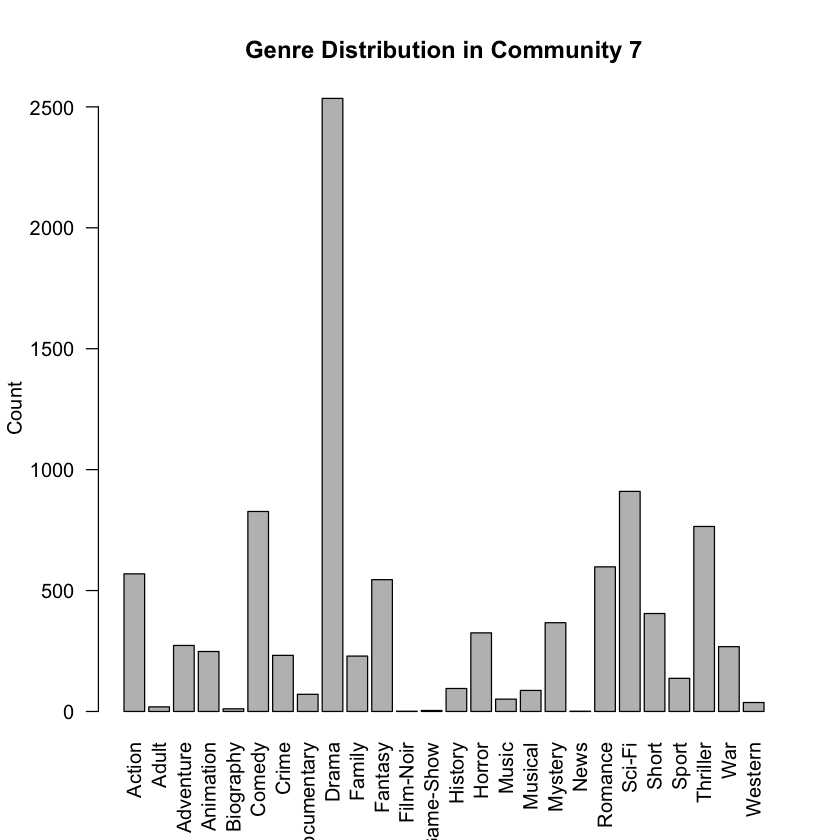

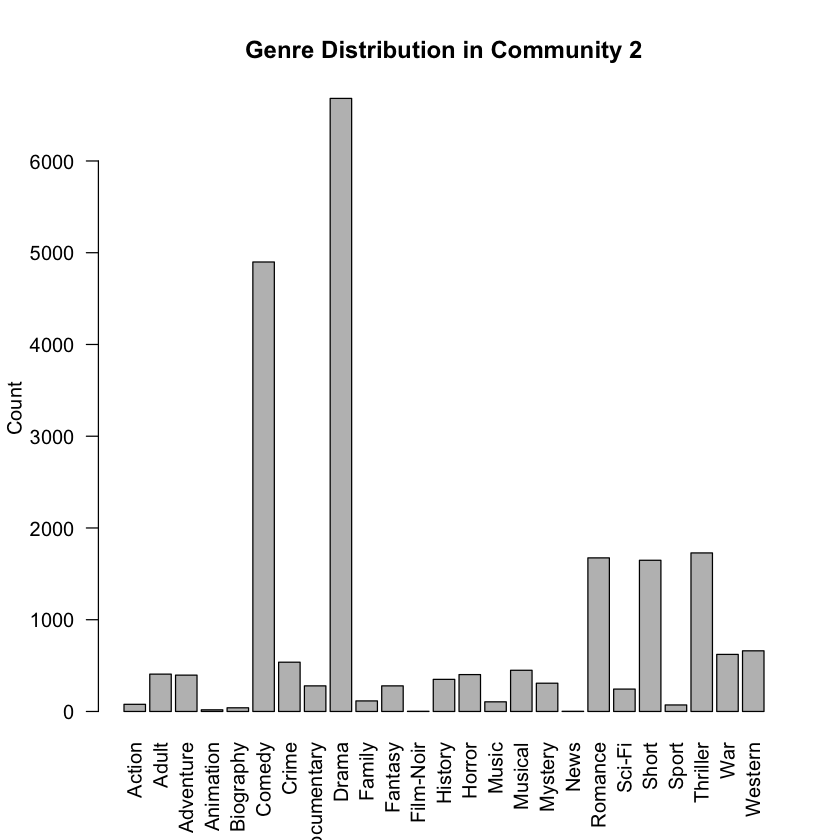

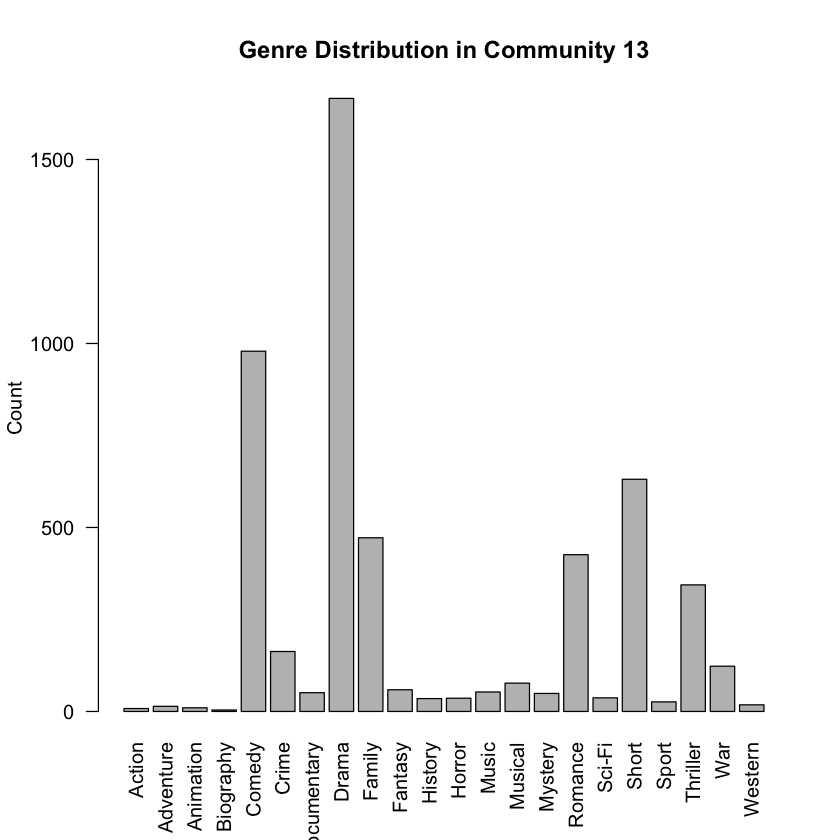

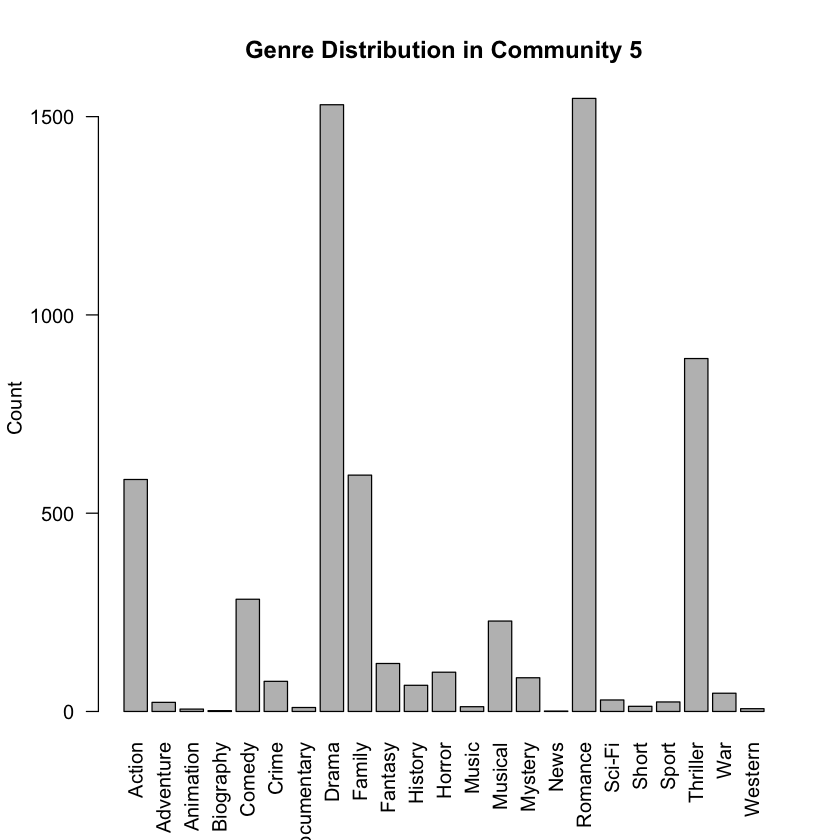

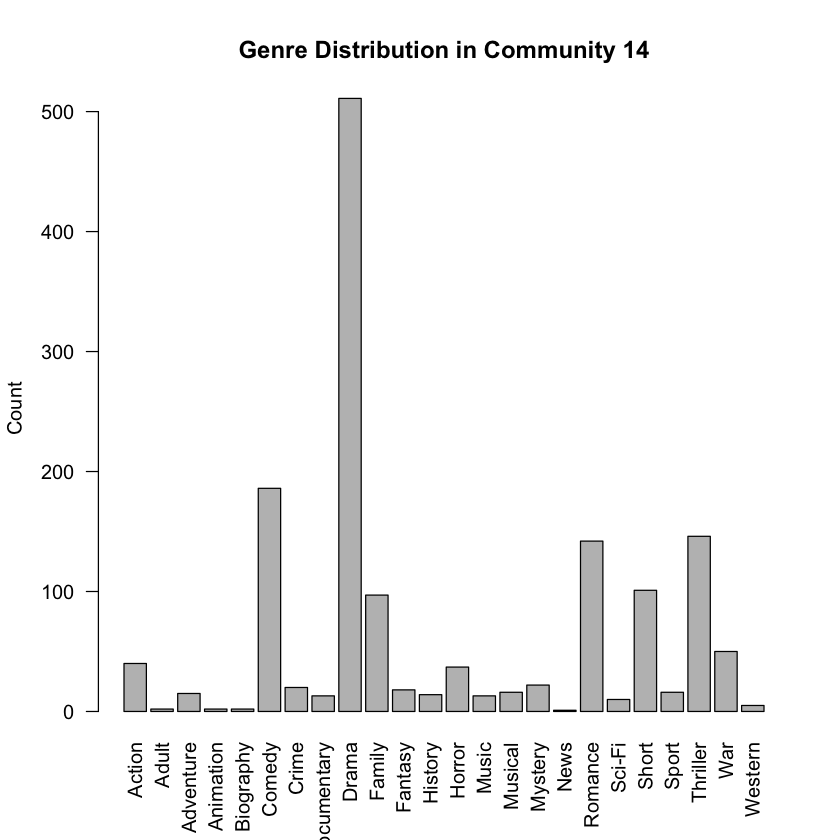

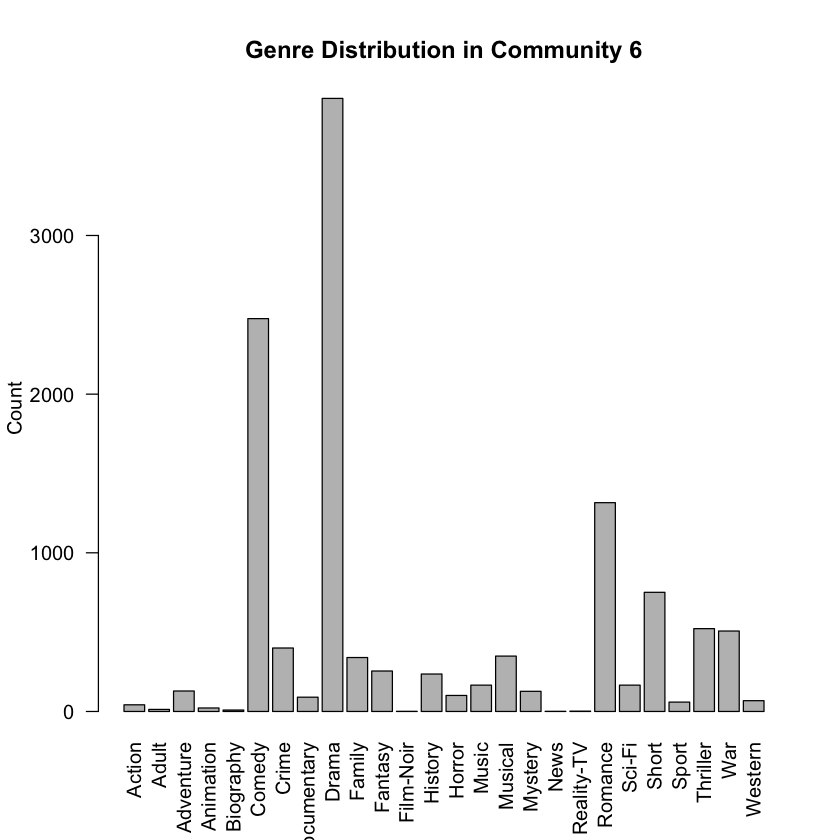

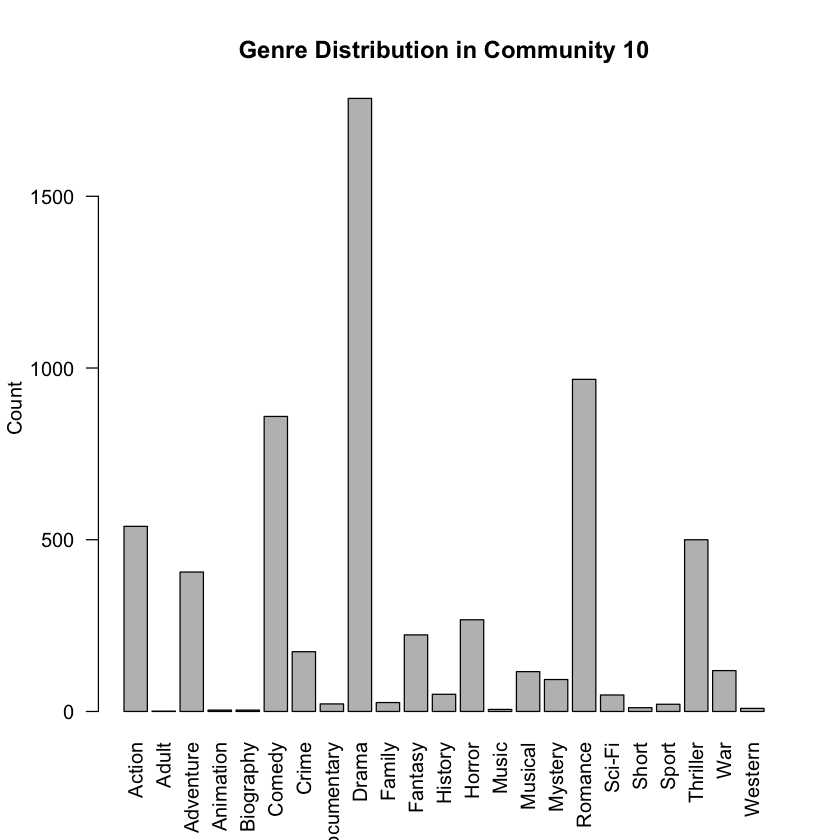

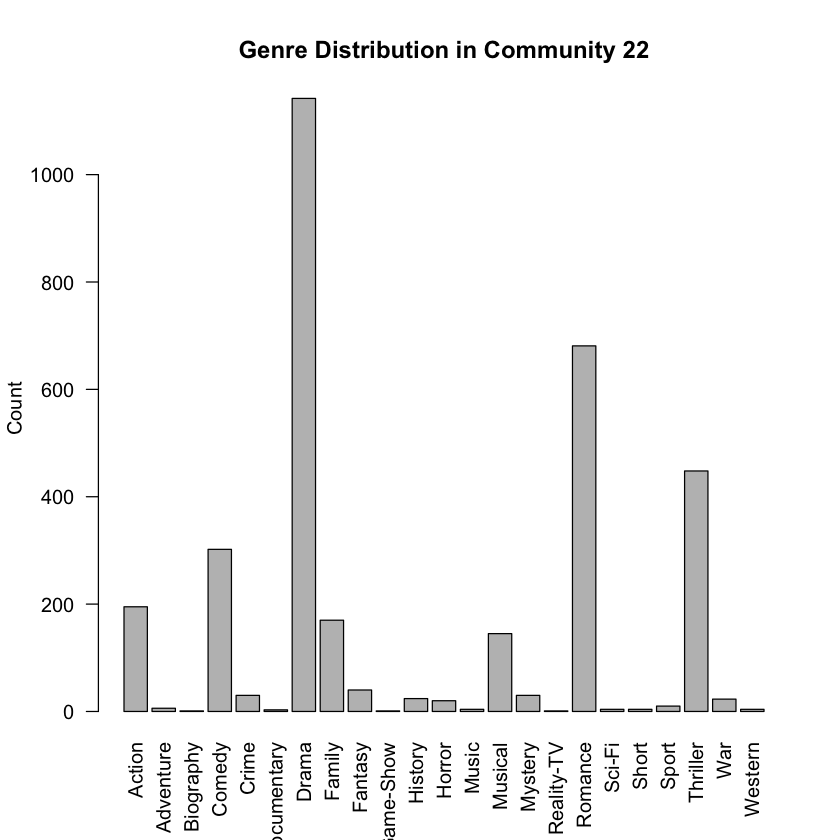

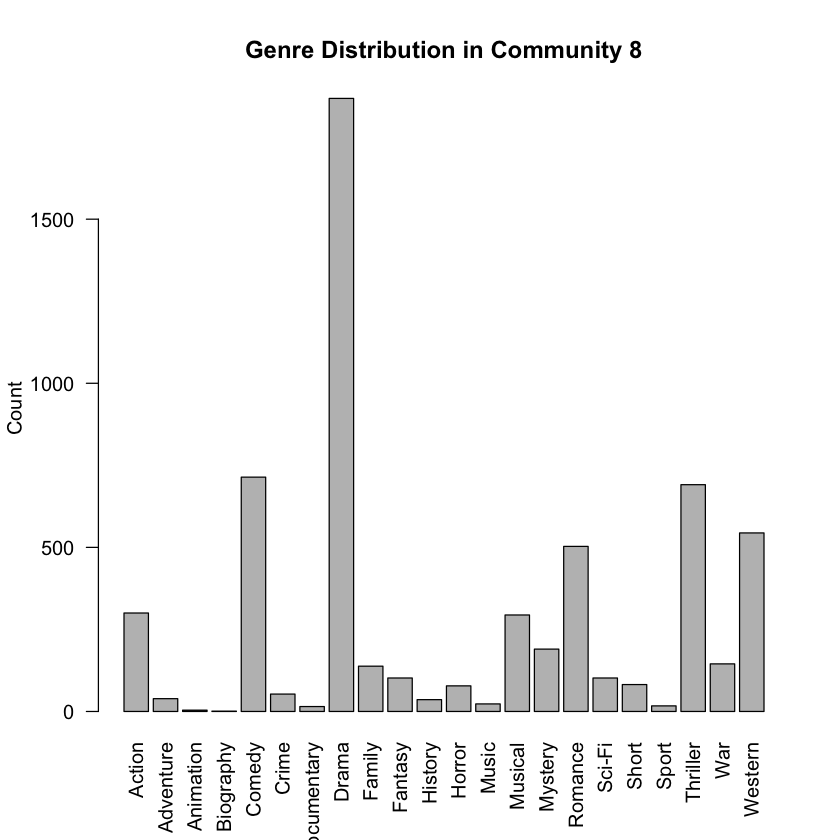

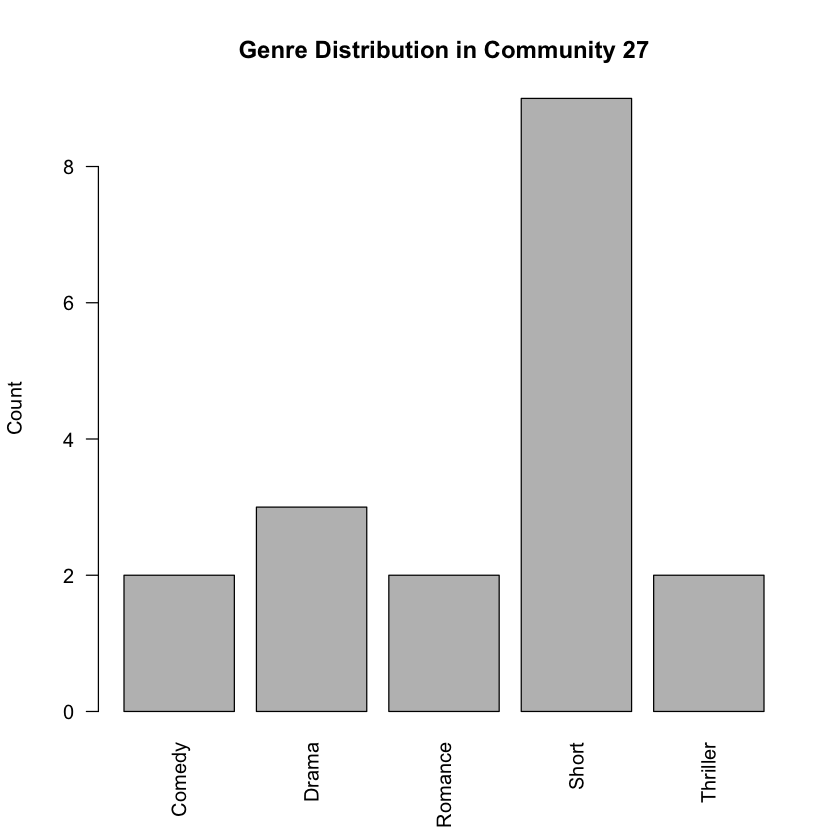

In [69]:
for (i in communities) {
    genre_list <- V(g.genre)[g.genre.fgc[[i]]]$genre
    genre_list <- genre_list[genre_list != "None"]
    genre.table <- table(genre_list)
    genre.freq <- prop.table(genre.table)
    
    Genre <- names(genre.table)
    Count <- as.vector(genre.table)
    Freq <- round(as.vector(genre.freq), 4)
    
    title = sprintf("Genre Distribution in Community %d", i)
    barplot(Count, main = title, ylab = "Count", names.arg = Genre, las=2)

}

### Question 8(b)

In [70]:
# genre score
genre_score <- function(c, p, q) {
    z = c * p / q
    log(z, base = exp(1))
}

In [75]:
# number of movies in this dataset
num_movies <- vcount(g.genre)

for (i in communities) {
    genre_list <- V(g.genre)[g.genre.fgc[[i]]]$genre
    genre_list <- genre_list[genre_list != "None"]
    genre.table <- table(genre_list)
    genre.freq <- prop.table(genre.table)
    
    Genre <- names(genre.table)
    Count <- as.vector(genre.table)
    Freq <- round(as.vector(genre.freq), 4)
    score <- genre_score(Count, Freq, Count / num_movies)
    
    cat("======= Community", i, "=======\n")
    cat("============================\n")

    df <- data.frame(Genre, score)
    print(df)
    cat("\n\n")
}

======= Community 7 =======
         Genre     score
1       Action  9.396882
2        Adult  6.009108
3    Adventure  8.662350
4    Animation  8.566335
5    Biography  5.411271
6       Comedy  9.771470
7        Crime  8.498173
8  Documentary  7.317441
9        Drama 10.891152
10      Family  8.485646
11     Fantasy  9.353735
12   Film-Noir  3.013376
13   Game-Show  4.399670
14     History  7.608496
15      Horror  8.836422
16       Music  6.983668
17     Musical  7.524235
18     Mystery  8.958796
19        News  3.013376
20     Romance  9.446316
21      Sci-Fi  9.866675
22       Short  9.056009
23       Sport  7.976220
24    Thriller  9.692975
25         War  8.644587
26     Western  6.676937


======= Community 2 =======
         Genre     score
1       Action  6.568724
2        Adult  8.233732
3    Adventure  8.206333
4    Animation  5.092817
5    Biography  5.903747
6       Comedy 10.721786
7        Crime  8.510544
8  Documentary  7.857563
9        Drama 11.032330
10      Family  6

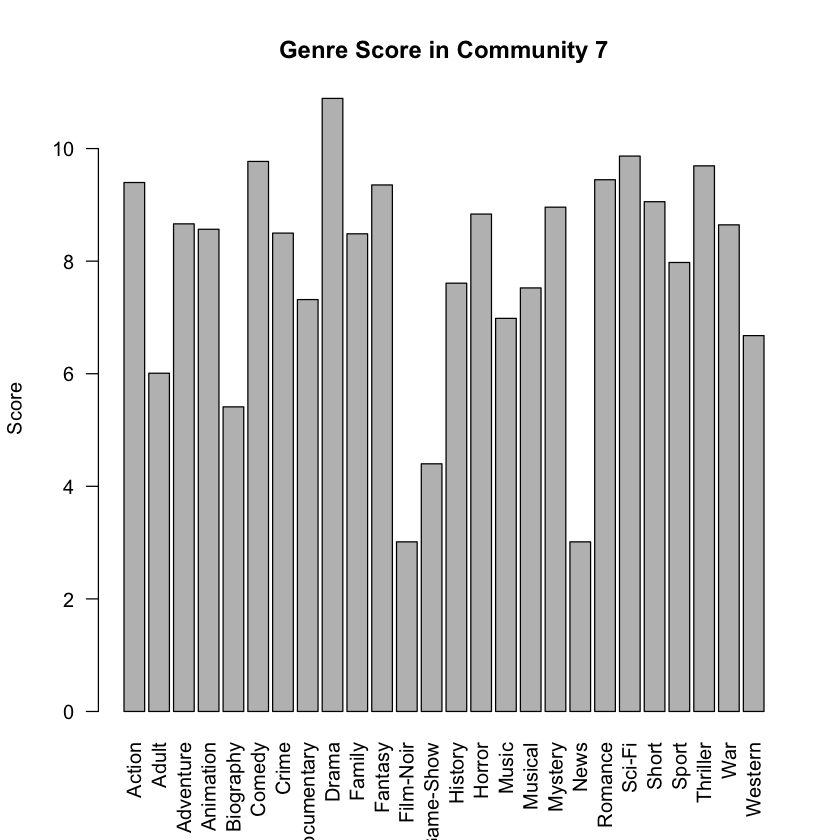

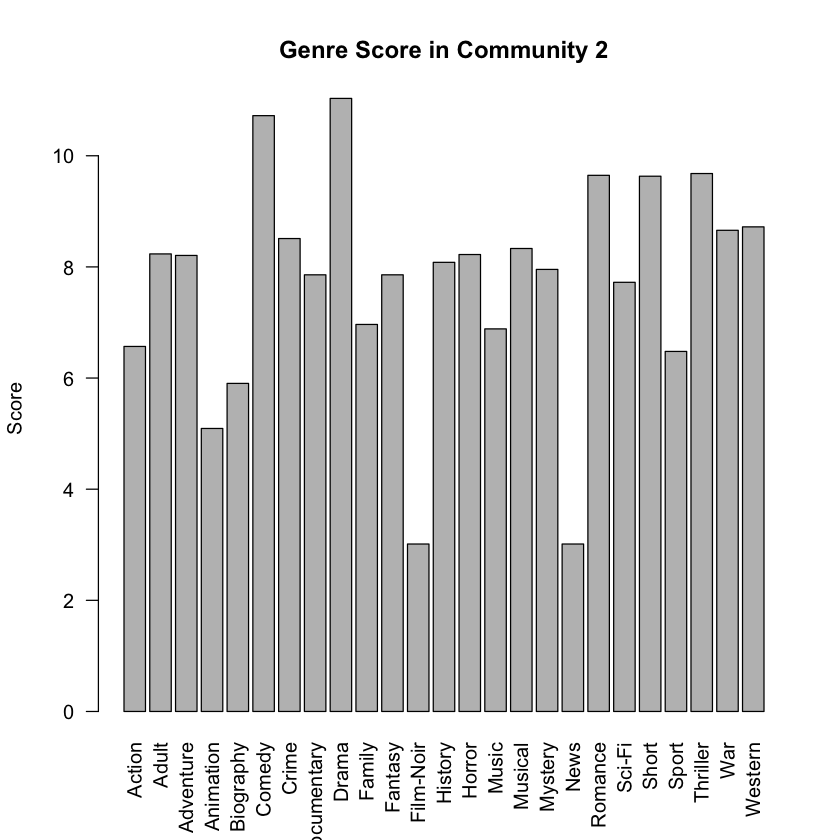

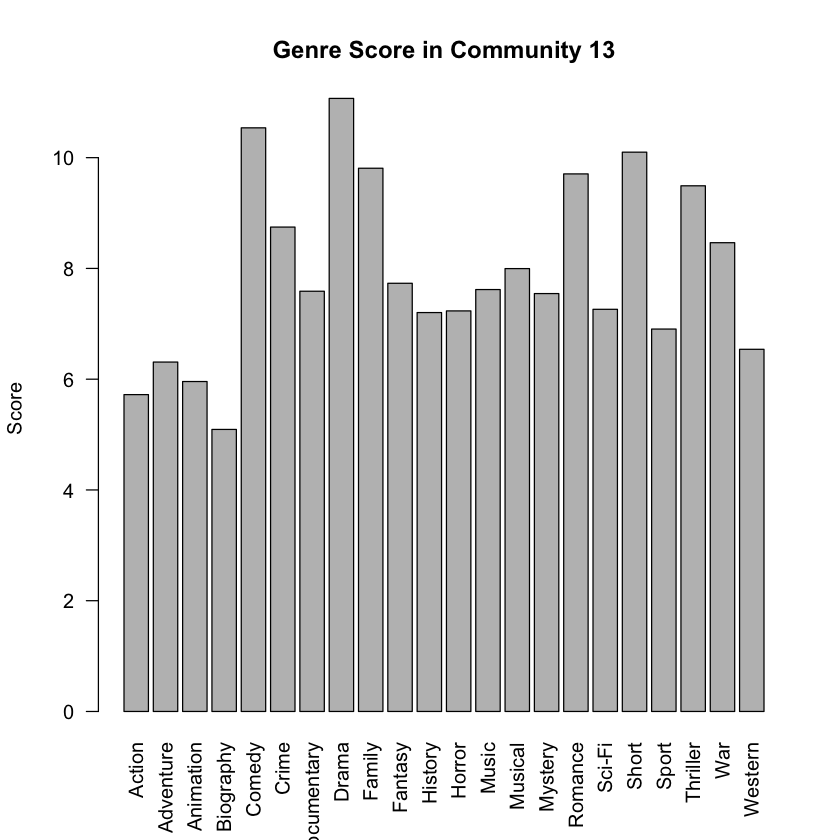

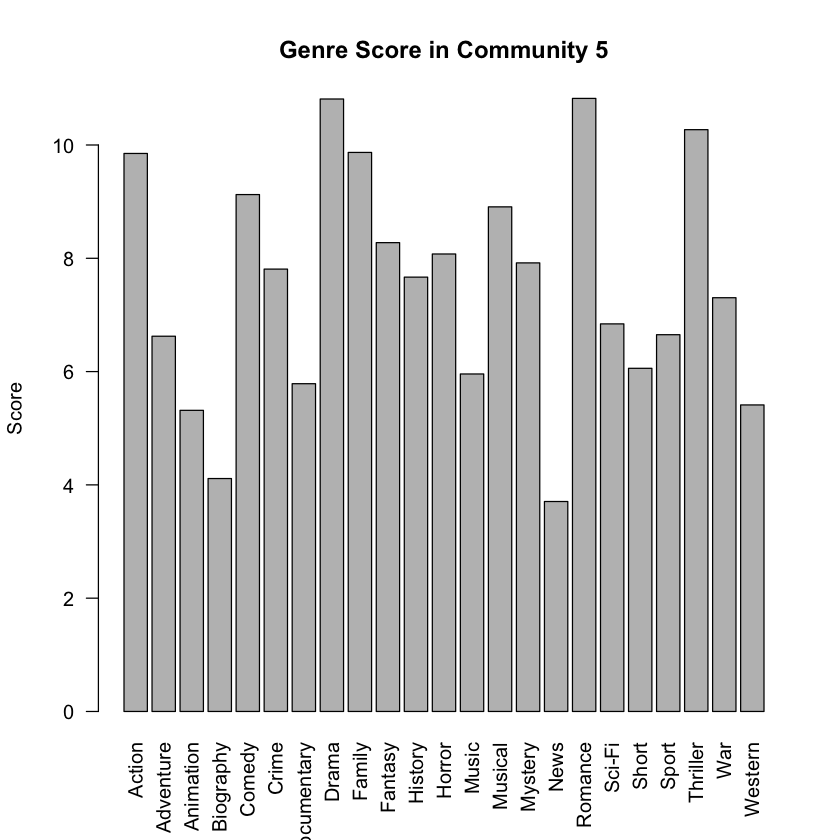

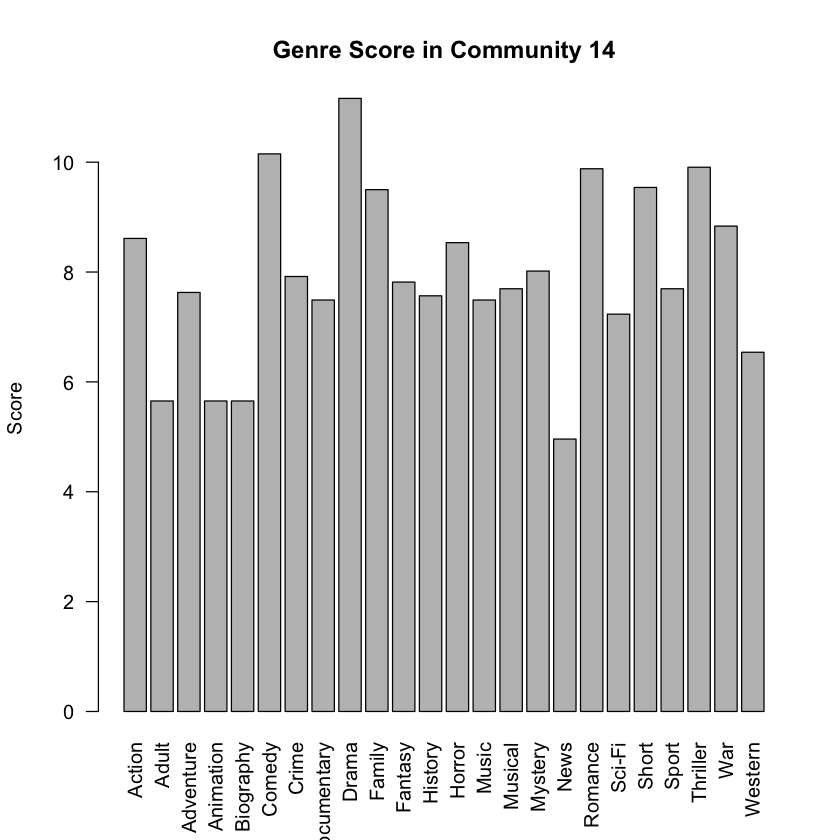

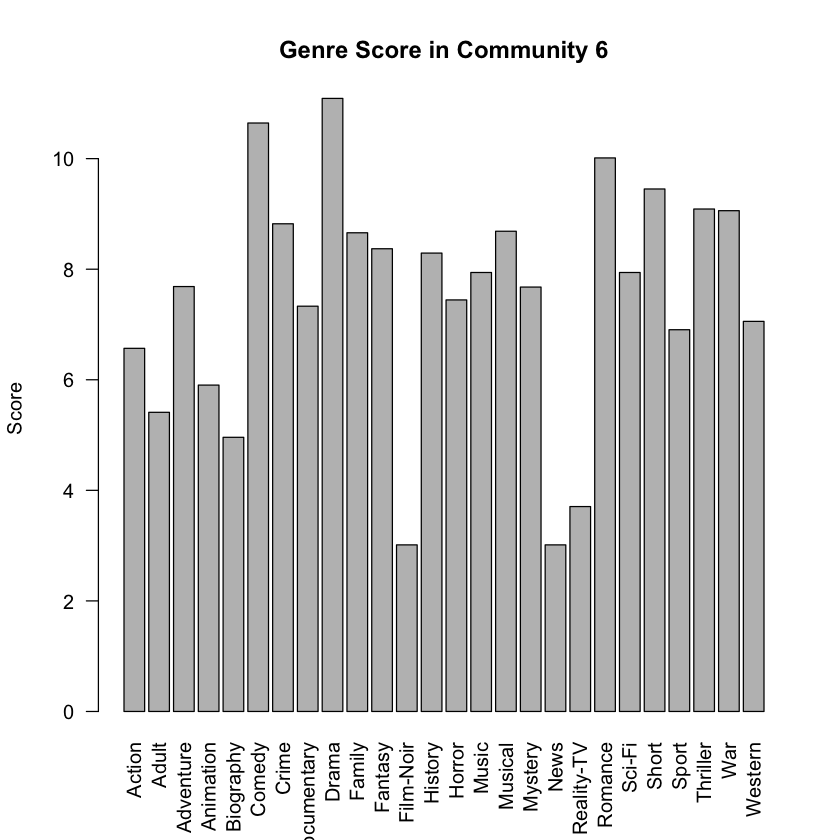

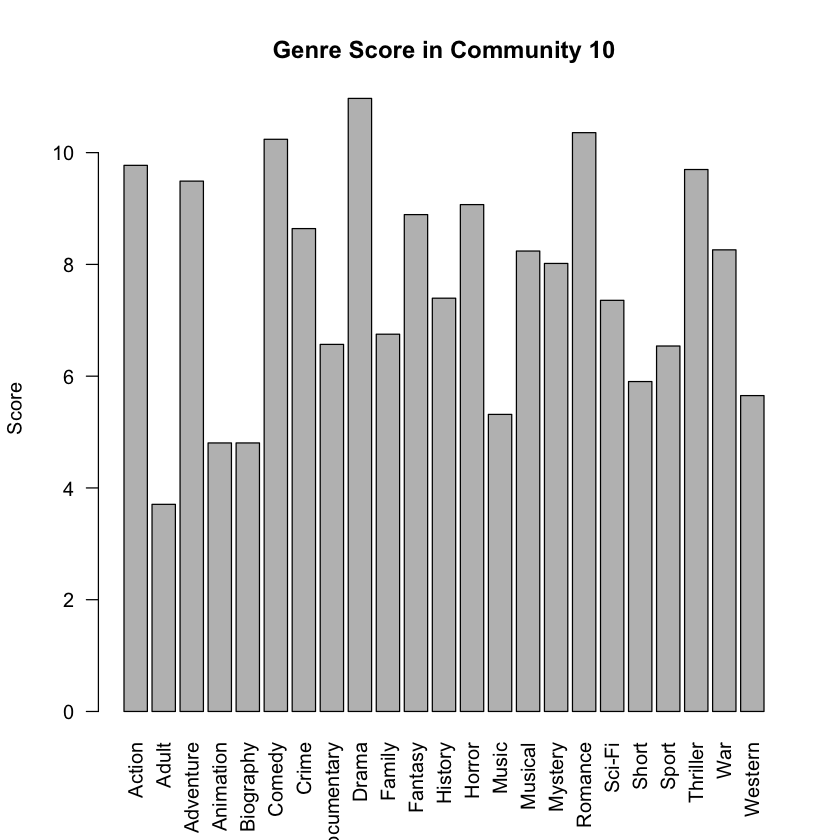

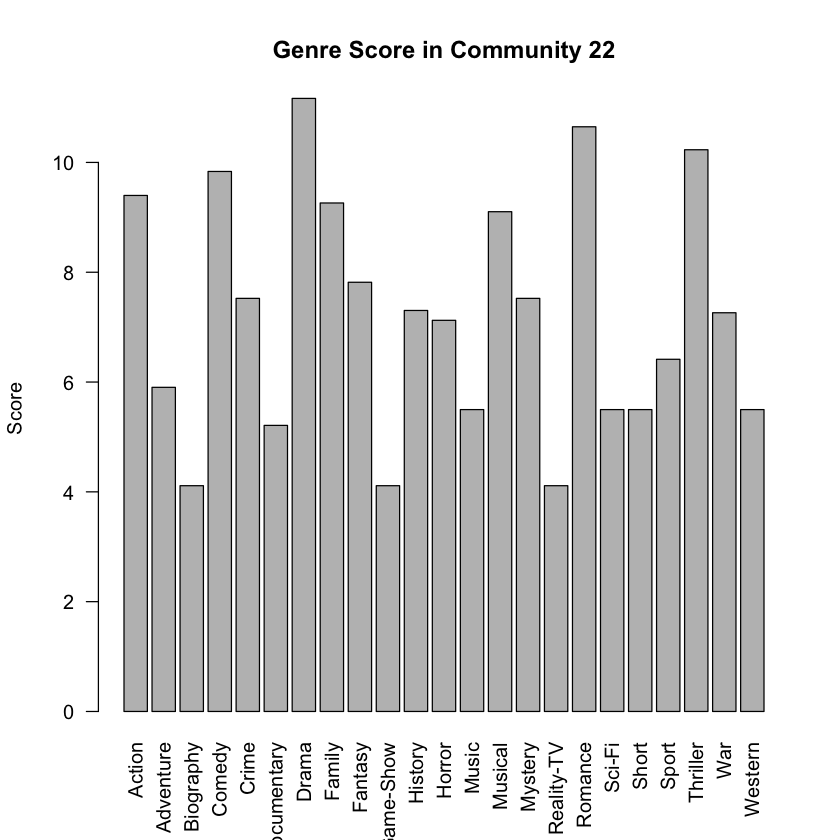

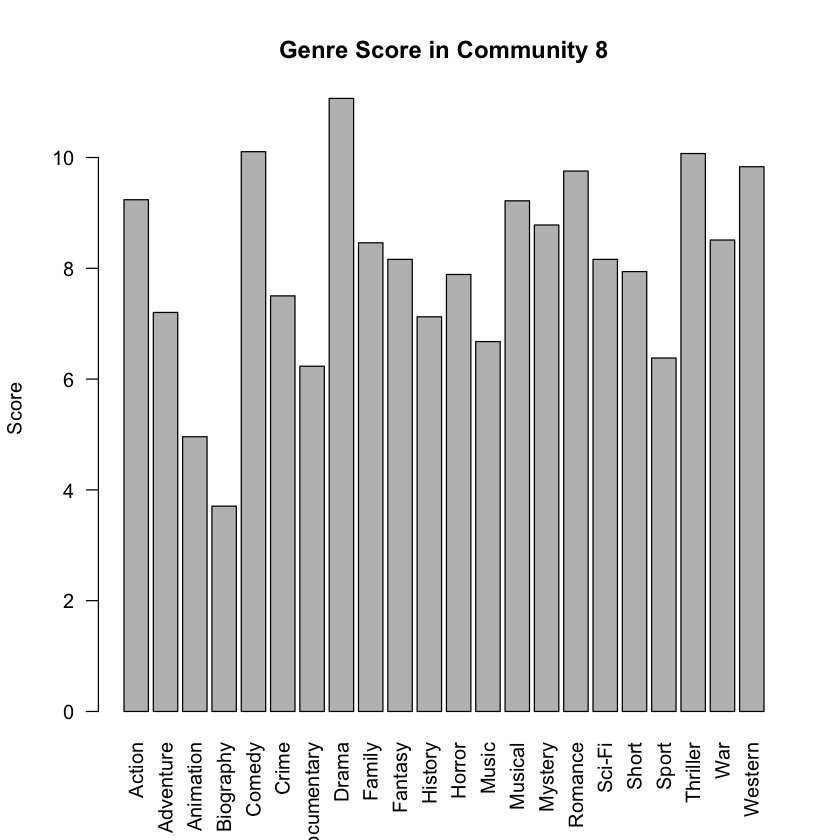

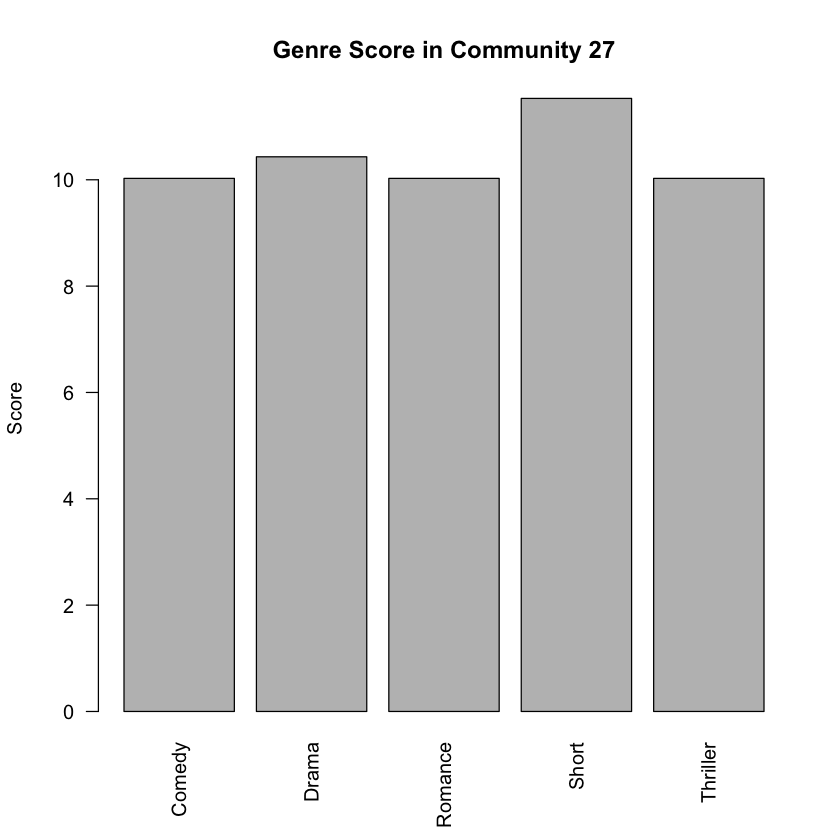

In [77]:
for (i in communities) {
    genre_list <- V(g.genre)[g.genre.fgc[[i]]]$genre
    genre_list <- genre_list[genre_list != "None"]
    genre.table <- table(genre_list)
    genre.freq <- prop.table(genre.table)
    
    Genre <- names(genre.table)
    Count <- as.vector(genre.table)
    Freq <- round(as.vector(genre.freq), 4)
    score <- genre_score(Count, Freq, Count / num_movies)
    
    title <- sprintf("Genre Score in Community %d", i)
    barplot(score, main = title, ylab = "Score", names.arg = Genre, las=2)
}

### Question 8(c)

In [78]:
small_communities <- g.genre.fgc[sizes(g.genre.fgc) >= 10 & sizes(g.genre.fgc) <= 20]

In [100]:
# find all movies in these communities
movie_id_list <- c()
for (i in 1:length(small_communities)) {
    movie_id_partial <- as.numeric(V(g.genre)[small_communities[[i]]]$name)
    movie_id_list <- c(movie_id_list, movie_id_partial)
}
movie_id_list <- as.character(sort(movie_id_list))

In [151]:
# build the edgelist for bipartite graph
movie_actors_file <- file("./data/movie_actors.txt", open="r")
line <- readLines(movie_actors_file, 1, encoding="latin1")

# index of movie_id_list
idx <- 1

# edgelist
movie_id_edge <- c()
actor_id_edge <- c()

while(length(line) != 0) {    
    line <- strsplit(line,"\t\t")
    movie_id <- line[[1]][2]
    actor_id <- line[[1]][3:length(line[[1]])]
    
    if (movie_id == movie_id_list[idx]) {
        movie_id_edge <- c(movie_id_edge, rep(paste("m",movie_id), length(actor_id)))
        actor_id_edge <- c(actor_id_edge, actor_id)
        idx <- idx + 1
    }

    if (idx > length(movie_id_list)) {
        break
    }
    line <- readLines(movie_actors_file, 1, encoding="latin1")
} 
close(movie_actors_file)

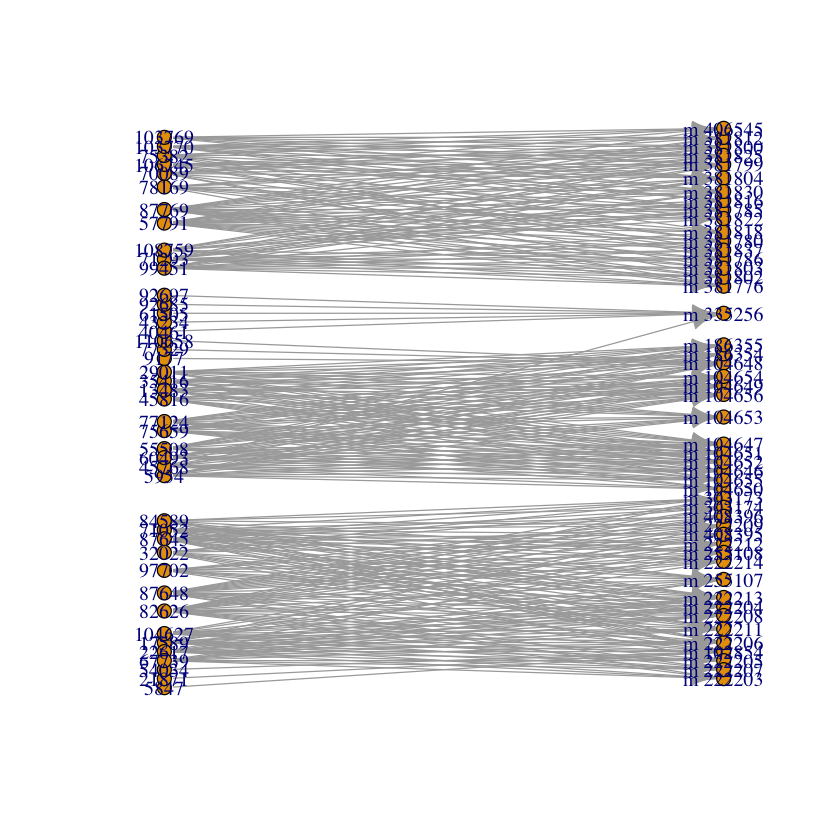

In [161]:
# build the bipartite graph
edge_df <- data.frame(actor_id_edge, movie_id_edge)
g.bi <- graph_from_data_frame(edge_df)
V(g.bi)$type <- V(g.bi)$name %in% actor_id_edge
l <- layout_as_bipartite(g.bi)
plot(g.bi, layout=l[, c(2,1)], vertex.size = 5)

0,0.0
0,5.0
0,1.0
0,4.0
0,2.0
0,17.5
0,8.5
0,18.5
0,16.5
0,10.5
0,13.0


In [120]:
actor_id

[1] "0"      "24641"  "31164"  "47282"  "57240"  "93429"  "112532"